In [1]:
import os
import glob
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split

In [2]:
def load_data_from_npz(directory):
    file_list = glob.glob(os.path.join(directory, "*.npz"))
    all_trajectories = []
    for f in file_list:
        with np.load(f) as data:
            pos_x = data["pos_x"]
            pos_y = data["pos_y"]
            v_x = data["v_x"]
            v_y = data["v_y"]

            length = len(pos_x)
            if length < 10:
                continue

            features = np.stack([pos_x, pos_y, v_x, v_y], axis=-1)
            target = np.array([pos_x[-1], pos_y[-1]], dtype=np.float32)
            input_seq = features[:9]
            full_x = pos_x
            full_y = pos_y
            all_trajectories.append((input_seq, target, full_x, full_y))
    return all_trajectories


data_dir = "dataset/eth"
all_data = load_data_from_npz(data_dir)  # list of (input_seq, target)

train_ratio = 0.7
val_ratio = 0.1
test_ratio = 0.2

train_val_data, test_data = train_test_split(all_data, test_size=test_ratio, random_state=42)
val_size = val_ratio / (train_ratio + val_ratio)
train_data, val_data = train_test_split(train_val_data, test_size=val_size, random_state=42)


In [4]:
def prepare_data(data_list):
    X_list = []
    Y_list = []
    full_x_list = []
    full_y_list = []
    for (inp, tgt, fx, fy) in data_list:
        X_list.append(inp)
        Y_list.append(tgt)
        full_x_list.append(fx)
        full_y_list.append(fy)

    X = np.array(X_list, dtype=np.float32)
    Y = np.array(Y_list, dtype=np.float32)
    return X, Y, full_x_list, full_y_list


In [5]:
X_train, Y_train, full_x_train, full_y_train = prepare_data(train_data)
X_val, Y_val, full_x_val, full_y_val = prepare_data(val_data)
X_test, Y_test, full_x_test, full_y_test = prepare_data(test_data)


In [6]:
model = Sequential()
model.add(LSTM(64, input_shape=(9, X_train.shape[-1])))  # 5个时间步, 每个时间步4个特征
model.add(Dense(2))  # 输出终点(x, y)

model.compile(loss='mse', optimizer='adam', metrics=['mae'])
model.summary()

C:\Users\13498\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 64)                  │          17,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,794 (69.51 KB)

 Trainable params: 17,794 (69.51 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
]

history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=50,     # 可以根据需要调整
    batch_size=32,
    callbacks=callbacks
)

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - loss: 70.6705 - mae: 7.0962 - val_loss: 57.9039 - val_mae: 6.5297
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 61.1560 - mae: 6.6084 - val_loss: 49.0057 - val_mae: 5.9936
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 52.4370 - mae: 6.1552 - val_loss: 39.9779 - val_mae: 5.4226
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 41.0428 - mae: 5.4346 - val_loss: 30.8441 - val_mae: 4.7836
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 33.4679 - mae: 4.9947 - val_loss: 22.4304 - val_mae: 4.1072
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 25.6730 - mae: 4.4524 - val_loss: 15.5925 - val_mae: 3.4559
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 18.3107 - mae: 3.7057 - val_loss: 10.5181 - val_mae: 2.8480
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 11.9621 - mae: 2.9129 - val_loss: 7.3334 - val_mae: 2.3675
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 9.4443 -

In [8]:
test_loss, test_mae = model.evaluate(X_test, Y_test, verbose=0)
print("Test Loss:", test_loss)
print("Test MAE:", test_mae)
predictions = model.predict(X_test[:5])
print("Predictions:\n", predictions)
print("Ground Truth:\n", Y_test[:5])

Test Loss: 4.5131425857543945
Test MAE: 1.1009736061096191
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step
Predictions:
 [[10.139965   6.11199  ]
 [-1.422334   6.8783064]
 [10.04773    6.1623993]
 [12.485681   5.382486 ]
 [-0.8232831  7.7244997]]
Ground Truth:
 [[-2.7650094   3.8288734 ]
 [-5.4628325   4.5656233 ]
 [-2.2585204   9.9833765 ]
 [12.369087    4.146375  ]
 [-0.53976214  6.9240856 ]]


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step 


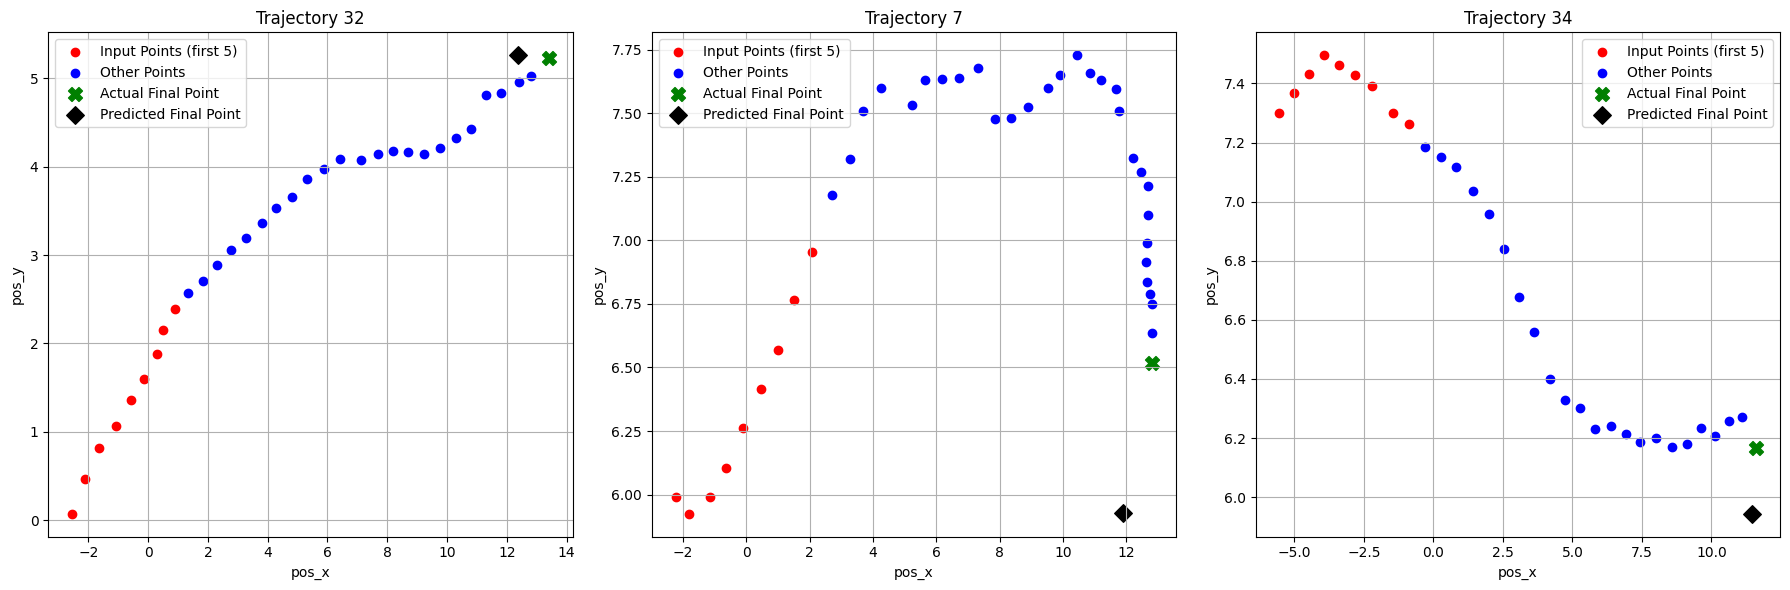

In [9]:
import numpy as np
import matplotlib.pyplot as plt

predictions = model.predict(X_test)
idxs = np.random.choice(len(X_test), 3, replace=False)

fig, axes = plt.subplots(1, 3, figsize=(18, 6)) 

for i, idx in enumerate(idxs):
    ax = axes[i]

    input_pos_x = X_test[idx][:, 0]
    input_pos_y = X_test[idx][:, 1]
    actual_final = Y_test[idx]   # [final_x, final_y]
    pred_final = predictions[idx]
    full_traj_x = full_x_test[idx]
    full_traj_y = full_y_test[idx]

    # 前5个点: 红色
    ax.scatter(input_pos_x, input_pos_y, color='red', label='Input Points (first 5)')

    # 中间点（如果存在, 即从第6个点到倒数第二个点）
    if len(full_traj_x) > 10:
        ax.scatter(full_traj_x[9:-1], full_traj_y[9:-1], color='blue', label='Other Points')

    # 实际最终点：绿色
    ax.scatter(full_traj_x[-1], full_traj_y[-1], color='green', label='Actual Final Point', marker='X', s=100)

    # 预测的最终点：黑色
    ax.scatter(pred_final[0], pred_final[1], color='black', label='Predicted Final Point', marker='D', s=80)

    ax.set_title(f"Trajectory {idx}")
    ax.set_xlabel("pos_x")
    ax.set_ylabel("pos_y")
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.show()
